In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

In [3]:
df = pd.read_csv("irisdata.csv")

df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.drop(columns=['Id'], inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

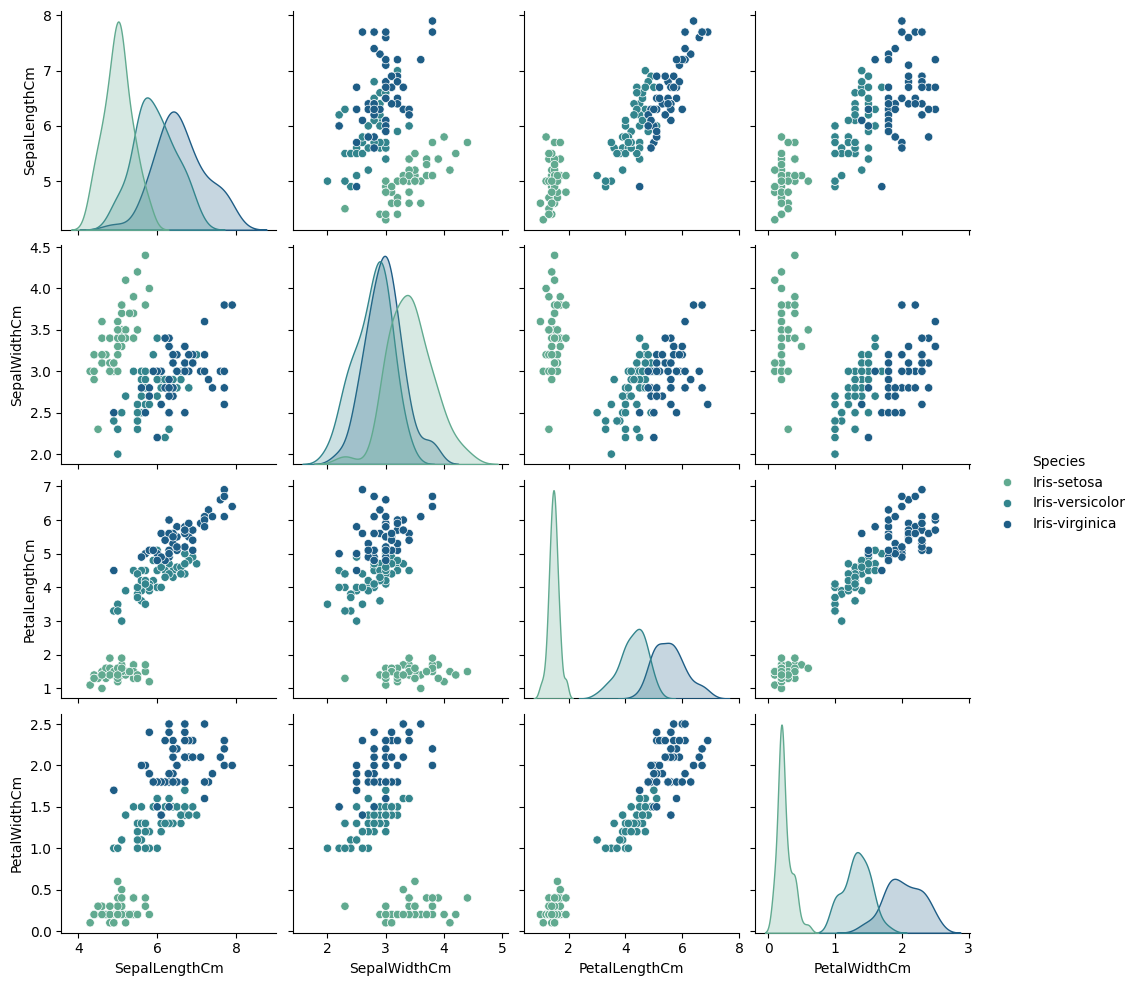

In [6]:
import seaborn as sns
sns.pairplot(df, hue='Species', palette='crest')

In [7]:
df["species"] = df["Species"].map({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2})

#features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [26]:
def train_test_split_manual(X, y, test_size=0.2, random_seed=27):
    np.random.seed(random_seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(len(X) * (1 - test_size))
    return X[indices[:split_idx]], X[indices[split_idx:]], y[indices[:split_idx]], y[indices[split_idx:]]

X_train, X_test, y_train, y_test = train_test_split_manual(X, y)


In [27]:
#decision Tree 
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_labels = np.unique(y)

        if depth >= self.max_depth or len(unique_labels) == 1 or num_samples < self.min_samples_split:
            return Node(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold = self._best_split(X, y, num_features)
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feature] <= best_threshold
        right_idx = ~left_idx
        left_subtree = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y, num_features):
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                if sum(left_idx) == 0 or sum(right_idx) == 0:
                    continue
                
                gini = self._gini_index(y[left_idx], y[right_idx])
                if gini < best_gini:
                    best_gini, best_feature, best_threshold = gini, feature, threshold

        return best_feature, best_threshold

    def _gini_index(self, left_labels, right_labels):
        def gini(labels):
            counts = np.bincount(labels)
            probabilities = counts / sum(counts)
            return 1 - np.sum(probabilities**2)

        left_size, right_size = len(left_labels), len(right_labels)
        total_size = left_size + right_size
        return (left_size / total_size) * gini(left_labels) + (right_size / total_size) * gini(right_labels)

    def predict(self, X):
        return np.array([self._traverse_tree(self.root, x) for x in X])

    def _traverse_tree(self, node, x):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(node.left, x)
        return self._traverse_tree(node.right, x)


In [28]:
tree = DecisionTree(max_depth=5, min_samples_split=2)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

#I've tried with multiple (42,84,13,52,27) random states, accuracy is 100% for all.

Accuracy: 100.00%


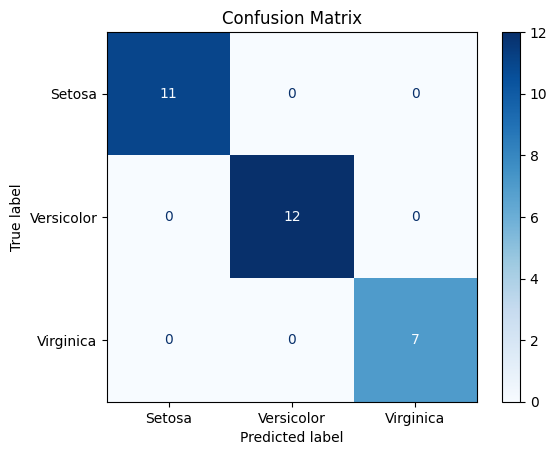

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Setosa", "Versicolor", "Virginica"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
